# Natalie Borovcova Assignment 2
## Bias in UK Police


## 1. Installing Dependecies

### Install all packages required to run the project

In [46]:
import sys
import requests
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install 'fsspec>=0.3.3'
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## 2. Using UK Data API to get available regions and dates.

### 2.1 Using the /crimes-street-dates API endpoint. 
We get a list of objects. Each object consists of two properties: date and stop-and-search. Dates consists of a year and a month, stop-and-search consits of all the regions that have recorded crime data during that month.

In [3]:
regions_with_dates = requests.get('https://data.police.uk/api/crimes-street-dates')  


### 2.2 Covert the HTTP response into a JSON object and then normalize it into a flat table using Pandas


In [4]:
regions_with_dates_json = regions_with_dates.json() 
regions_with_dates_flat_table = pd.json_normalize(regions_with_dates_json)
regions_with_dates_flat_table.head()

,date,stop-and-search
0,2021-02,"[avon-and-somerset, bedfordshire, btp, cambrid..."
1,2021-01,"[avon-and-somerset, bedfordshire, btp, cambrid..."
2,2020-12,"[avon-and-somerset, bedfordshire, btp, cambrid..."
3,2020-11,"[avon-and-somerset, bedfordshire, btp, cambrid..."
4,2020-10,"[avon-and-somerset, bedfordshire, btp, cambrid..."


In [5]:
available_police_force_regions = regions_with_dates_flat_table['stop-and-search'][0]
available_police_force_regions

['avon-and-somerset',
 'bedfordshire',
 'btp',
 'cambridgeshire',
 'cheshire',
 'city-of-london',
 'cleveland',
 'cumbria',
 'derbyshire',
 'devon-and-cornwall',
 'dorset',
 'durham',
 'dyfed-powys',
 'essex',
 'gloucestershire',
 'gwent',
 'hampshire',
 'hertfordshire',
 'humberside',
 'kent',
 'lancashire',
 'leicestershire',
 'merseyside',
 'metropolitan',
 'norfolk',
 'north-wales',
 'north-yorkshire',
 'northamptonshire',
 'northumbria',
 'nottinghamshire',
 'south-wales',
 'south-yorkshire',
 'staffordshire',
 'suffolk',
 'surrey',
 'sussex',
 'thames-valley',
 'warwickshire',
 'west-mercia',
 'west-midlands',
 'west-yorkshire']

In [6]:
months_with_data = regions_with_dates_flat_table['date'].unique()
months_with_data = np.sort(months_with_data)
months_with_data

array(['2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02',
       '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
       '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02'],
      dtype=object)

In [7]:
# list of forces
forces_list_df = pd.json_normalize(requests.get('https://data.police.uk/api/forces').json())
forces_list_df.head()

,id,name
0,avon-and-somerset,Avon and Somerset Constabulary
1,bedfordshire,Bedfordshire Police
2,cambridgeshire,Cambridgeshire Constabulary
3,cheshire,Cheshire Constabulary
4,city-of-london,City of London Police


### 2.3 Downloading and unpacking the main dataset 

In [8]:
!wget -N https://data.police.uk/data/archive/latest.zip
!unzip latest.zip

--2021-04-29 02:51:35--  https://data.police.uk/data/archive/latest.zip
Resolving data.police.uk (data.police.uk)... 52.208.127.213, 108.128.19.106
Connecting to data.police.uk (data.police.uk)|52.208.127.213|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://policeuk-data.s3.amazonaws.com/archive/2021-02.zip [following]
--2021-04-29 02:51:35--  https://policeuk-data.s3.amazonaws.com/archive/2021-02.zip
Resolving policeuk-data.s3.amazonaws.com (policeuk-data.s3.amazonaws.com)... 52.218.89.194
Connecting to policeuk-data.s3.amazonaws.com (policeuk-data.s3.amazonaws.com)|52.218.89.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1656873052 (1.5G) [binary/octet-stream]
Saving to: ‘latest.zip’

latest.zip          100%[===================>]   1.54G  21.7MB/s    in 76s     

2021-04-29 02:52:52 (20.9 MB/s) - ‘latest.zip’ saved [1656873052/1656873052]

Archive:  latest.zip
  inflating: 2018-03/2018-03-avon-and-somerset-street.c

## 3. Looking into stop and search data
### 3.1 Load the dataset using Dask and Pandas Dataframes


In [9]:
# Load data into pandas dataframes
force = 'metropolitan'
stop_and_search_dd = dd.read_csv("/content/*/*-" +force+"-stop-and-search.csv", 
                                 dtype={'Object of search': 'object', 'Age range': 'object'})
stop_and_search_df = stop_and_search_dd.compute()
stop_and_search_df


,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person and Vehicle search,2018-03-01T00:05:00+00:00,False,NaN,NaN,NaN,Male,NaN,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN,NaN
1,Person search,2018-03-01T00:10:00+00:00,False,NaN,NaN,NaN,Male,NaN,Asian/Asian British - Pakistani,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN
2,Person search,2018-03-01T00:10:00+00:00,False,NaN,NaN,NaN,Male,NaN,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN,NaN
3,Person search,2018-03-01T00:15:00+00:00,False,NaN,NaN,NaN,Male,NaN,Asian/Asian British - Pakistani,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN
4,Person and Vehicle search,2018-03-01T00:15:00+00:00,False,NaN,NaN,NaN,Male,NaN,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25077,Person and Vehicle search,2021-02-28T23:50:00+00:00,False,NaN,NaN,NaN,Male,25-34,Other ethnic group - Any other ethnic group,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,NaN,NaN
25078,Person and Vehicle search,2021-02-28T23:50:00+00:00,False,NaN,51.368050,-0.098791,Male,over 34,Black/African/Caribbean/Black British - African,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN,NaN
25079,Person search,2021-02-28T23:50:00+00:00,False,NaN,51.522956,-0.193713,Male,18-24,Other ethnic group - Not stated,Other,Criminal Justice and Public Order Act 1994 (se...,Anything to threaten or harm anyone,A no further action disposal,NaN,NaN
25080,Person search,2021-02-28T23:50:00+00:00,False,NaN,51.558159,-0.008051,Male,18-24,Asian/Asian British - Indian,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN


### 3.2 Remove duplicates from the data set


In [10]:
stop_and_search_df = stop_and_search_df.drop_duplicates()
stop_and_search_df.head().transpose()

,0,1,2,3,4
Type,Person and Vehicle search,Person search,Person search,Person search,Person and Vehicle search
Date,2018-03-01T00:05:00+00:00,2018-03-01T00:10:00+00:00,2018-03-01T00:10:00+00:00,2018-03-01T00:15:00+00:00,2018-03-01T00:15:00+00:00
Part of a policing operation,False,False,False,False,False
Policing operation,NaN,NaN,NaN,NaN,NaN
Latitude,NaN,NaN,NaN,NaN,NaN
Longitude,NaN,NaN,NaN,NaN,NaN
Gender,Male,Male,Male,Male,Male
Age range,NaN,NaN,NaN,NaN,NaN
Self-defined ethnicity,Black/African/Caribbean/Black British - Any ot...,Asian/Asian British - Pakistani,Black/African/Caribbean/Black British - African,Asian/Asian British - Pakistani,Asian/Asian British - Any other Asian background
Officer-defined ethnicity,Black,Asian,Black,Asian,Asian


### 3.3 Total number of stop and searches in the metropolitan area


In [11]:
total_number_of_stop_and_searches_london = len(stop_and_search_df)
total_number_of_stop_and_searches_london

735916

### 3.4 Figure 1
### Plot and table describing the number of stop and searches groupped by officer-defined ethnicity and outcome.

Officer-defined ethnicity,Asian,Black,Other,White
Outcome,,,,
A no further action disposal,96856,219117,24306,204723
Arrest,12671,37302,3580,36521
Caution (simple or conditional),89,153,13,242
Community resolution,10768,19094,2520,24047
Khat or Cannabis warning,333,594,58,738
Penalty Notice for Disorder,4908,6476,797,6045
Summons / charged by post,1853,3488,368,2968


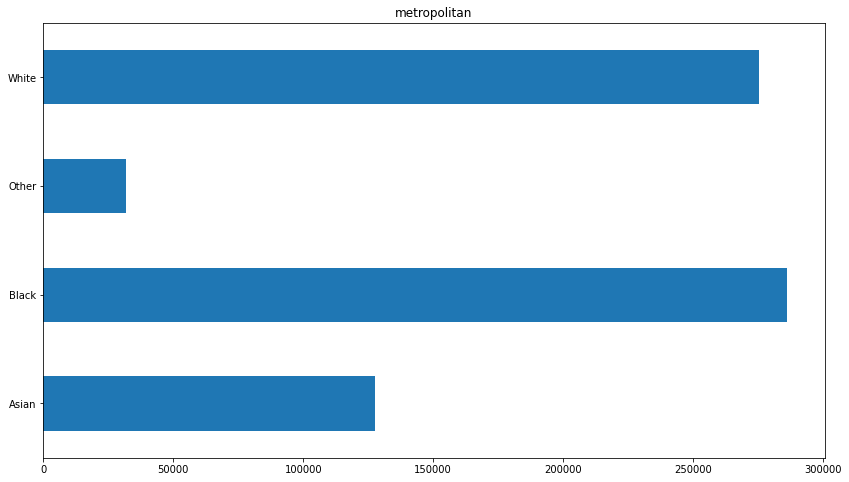

In [12]:
fig = plt.figure();
stop_and_search_df['Officer-defined ethnicity'].groupby(stop_and_search_df['Officer-defined ethnicity']).count().plot.barh(figsize=(14,8));
plt.ylabel(None);
plt.title(force);
stop_and_search_df['Officer-defined ethnicity'].groupby(stop_and_search_df['Officer-defined ethnicity']).count()
total_number_of_stop_and_searches_london = len(stop_and_search_df)
total_number_of_stop_and_searches_london
stop_and_search_grouped2 = stop_and_search_df.groupby(['Officer-defined ethnicity','Outcome'])['Outcome'].count().unstack(fill_value=0)
stop_and_search_grouped2.head().transpose()

### 3.5 Figure 2
### Plot describing the number of stop and searches that ended up with an action

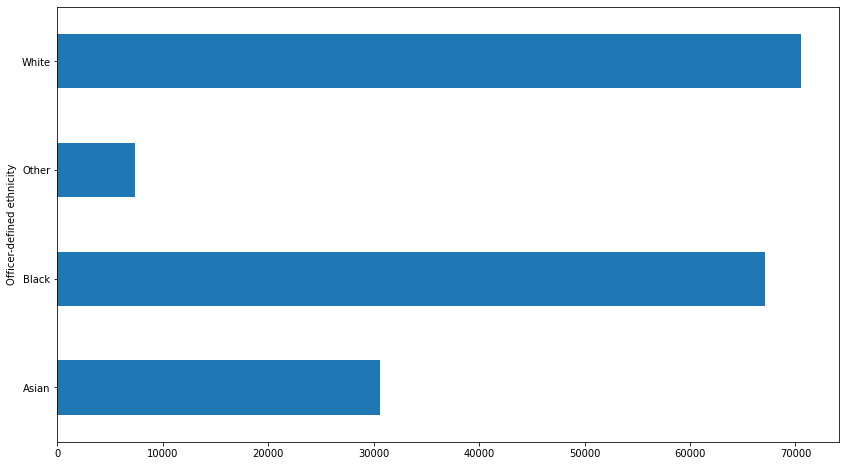

In [13]:
stop_and_search_df_arrest_outcome = stop_and_search_df[stop_and_search_df['Outcome'] != 'A no further action disposal']
fig = plt.figure();
stop_and_search_df_arrest_outcome['Outcome'].groupby(stop_and_search_df_arrest_outcome['Officer-defined ethnicity']).count().plot.barh(figsize=(14,8));

###3.6 Quick correlation

In [44]:
dummy.corr()

The correlation between number of statuses and followers:


,Outcome_A no further action disposal,Outcome_Arrest,Outcome_Caution (simple or conditional),Outcome_Community resolution,Outcome_Khat or Cannabis warning,Outcome_Penalty Notice for Disorder,Outcome_Summons / charged by post,Gender_Female,Gender_Male,Gender_Other,Officer-defined ethnicity_Asian,Officer-defined ethnicity_Black,Officer-defined ethnicity_Other,Officer-defined ethnicity_White,Type_Person and Vehicle search,Type_Person search,Type_Vehicle search
Outcome_A no further action disposal,1.000000,-0.665777,-0.046308,-0.512526,-0.085557,-0.284383,-0.195024,0.003828,0.005010,0.003694,0.004427,0.018406,0.006179,-0.021499,-0.106462,0.110353,-0.021568
Outcome_Arrest,-0.665777,1.000000,-0.009971,-0.110353,-0.018421,-0.061231,-0.041991,-0.010583,0.002861,-0.002555,-0.035910,0.011919,-0.007832,0.017017,0.063464,-0.067090,0.017322
Outcome_Caution (simple or conditional),-0.046308,-0.009971,1.000000,-0.007676,-0.001281,-0.004259,-0.002921,0.001109,-0.001149,-0.000658,0.000090,-0.004804,-0.002273,0.005466,-0.001738,0.001498,0.000687
Outcome_Community resolution,-0.512526,-0.110353,-0.007676,1.000000,-0.014181,-0.047137,-0.032325,0.022242,-0.020968,-0.002014,0.010512,-0.034419,0.001058,0.026053,0.030926,-0.030627,0.001377
Outcome_Khat or Cannabis warning,-0.085557,-0.018421,-0.001281,-0.014181,1.000000,-0.007869,-0.005396,0.000901,0.000586,-0.000094,0.002363,-0.004707,-0.002309,0.005083,0.015518,-0.014498,-0.002285
Outcome_Penalty Notice for Disorder,-0.284383,-0.061231,-0.004259,-0.047137,-0.007869,1.000000,-0.017936,-0.018738,0.011481,-0.000241,0.037794,-0.014490,-0.000403,-0.017309,0.072687,-0.075023,0.013628
Outcome_Summons / charged by post,-0.195024,-0.041991,-0.002921,-0.032325,-0.005396,-0.017936,1.000000,-0.011277,0.006616,-0.001280,0.009964,0.000258,-0.001007,-0.009662,0.038891,-0.040964,0.010107
Gender_Female,0.003828,-0.010583,0.001109,0.022242,0.000901,-0.018738,-0.011277,1.000000,-0.901836,-0.006740,-0.062373,-0.062026,-0.032969,0.130612,-0.034900,0.042705,-0.029399
Gender_Male,0.005010,0.002861,-0.001149,-0.020968,0.000586,0.011481,0.006616,-0.901836,1.000000,-0.083512,0.078536,0.095072,0.040108,-0.082490,0.059857,0.046420,-0.358789
Gender_Other,0.003694,-0.002555,-0.000658,-0.002014,-0.000094,-0.000241,-0.001280,-0.006740,-0.083512,1.000000,0.000646,-0.002179,0.000608,-0.002103,-0.004285,0.004626,-0.001497


## 4. Training machine learning algorithm to predict the outcome of stop and search




### 4.1 Preparing data and doing train test split

In [14]:
simplified_stop_and_search_df = stop_and_search_df[['Outcome','Gender','Officer-defined ethnicity', 'Type']]

In [15]:
simplified_stop_and_search_df
dummy = pd.get_dummies(simplified_stop_and_search_df)
dummy.head()

,Outcome_A no further action disposal,Outcome_Arrest,Outcome_Caution (simple or conditional),Outcome_Community resolution,Outcome_Khat or Cannabis warning,Outcome_Penalty Notice for Disorder,Outcome_Summons / charged by post,Gender_Female,Gender_Male,Gender_Other,Officer-defined ethnicity_Asian,Officer-defined ethnicity_Black,Officer-defined ethnicity_Other,Officer-defined ethnicity_White,Type_Person and Vehicle search,Type_Person search,Type_Vehicle search
0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0


In [16]:
x = dummy[['Gender_Female', 'Gender_Male','Gender_Other','Officer-defined ethnicity_Asian','Officer-defined ethnicity_Black','Officer-defined ethnicity_Other','Officer-defined ethnicity_White','Type_Person and Vehicle search','Type_Person search','Type_Vehicle search']]
y = dummy['Outcome_Arrest']
y.dropna()
x.dropna()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.003, random_state=42, shuffle=True)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(733708, 10)
(2208, 10)
(733708,)
(2208,)
0        1
1        0
2        1
3        0
4        0
        ..
25077    0
25078    1
25079    0
25080    0
25081    0
Name: Outcome_Arrest, Length: 735916, dtype: uint8


### 4.2 Using StandardScaler to scale train test data

In [17]:
st_scaler = StandardScaler()
x_train = st_scaler.fit_transform(x_train)
x_test = st_scaler.transform(x_test)
x_test
x_train
x_train[np.isnan(x_train)] = 0
y_train[0] = 0
x_test

array([[-0.26977032,  0.29911554, -0.02493767, ...,  1.81012704,
        -1.73145297, -0.12871152],
       [ 3.70685694, -3.34318975, -0.02493767, ..., -0.55244741,
         0.57754962, -0.12871152],
       [-0.26977032,  0.29911554, -0.02493767, ..., -0.55244741,
         0.57754962, -0.12871152],
       ...,
       [-0.26977032,  0.29911554, -0.02493767, ..., -0.55244741,
         0.57754962, -0.12871152],
       [-0.26977032,  0.29911554, -0.02493767, ..., -0.55244741,
         0.57754962, -0.12871152],
       [ 3.70685694, -3.34318975, -0.02493767, ..., -0.55244741,
         0.57754962, -0.12871152]])

###4.3 Logistical Regression

In [18]:
logitmod = LogisticRegression() 

y_train = np.array(y_train)
y_train
logitmod.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
pred_logit = logitmod.predict(x_test)
pred_logit

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [21]:
confusion_matrix(y_test, pred_logit)

array([[1912,    0],
       [ 296,    0]])

In [22]:
print(classification_report(y_test,pred_logit))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1912
           1       0.00      0.00      0.00       296

    accuracy                           0.87      2208
   macro avg       0.43      0.50      0.46      2208
weighted avg       0.75      0.87      0.80      2208



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn import metrics
y_pred=logitmod.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8659420289855072
Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###4.4 Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
model = LinearRegression().fit(x, y)

In [35]:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.006802374526735044
intercept: -99805655708.77165
slope: [-4.99312839e-02 -3.45819926e-02 -6.20003510e-02 -5.19792971e-03
  3.20061178e-02  1.36807562e-02  3.82217881e-02  9.98056557e+10
  9.98056557e+10  9.98056557e+10]


###4.5 KNeighbors Clasissifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knnmod = KNeighborsClassifier(n_neighbors=2)
knnmod.fit(x_train, y_train)

In [25]:
pred_knn = knnmod.predict(x_test)
pred_knn

In [26]:
confusion_matrix(y_test,pred_knn)

In [27]:
print(classification_report(y_test,pred_knn))

In [ ]:
from sklearn.model_selection import GridSearchCV
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1,30)}
knn_cv = GridSearchCV(knn2, param_grid, cv = 10)
knn_cv.fit(x_train,y_train)

In [ ]:
print(knn_cv.best_score_)
print(knn_cv.best_params_)

In [ ]:
pred_knn = knn_cv.predict(x_test)
print(classification_report(y_test,pred_knn))